# 顔検出 + 年齢・性別予測
###  顔検出はfacenetのMTCNN。これは精度よく検出できる
###  年齢・性別予測は学習済みのWideResNet。精度全然ダメ

In [1]:
!pwd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tf_2_work/predict-face-age-gender


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

## 顔検出

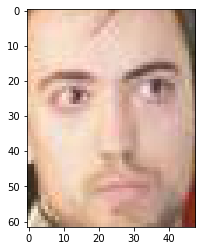

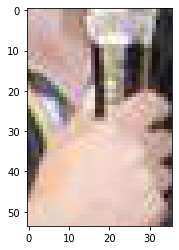

In [2]:
import sys
sys.path.append('./mtcnn')
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt

class FaceNetMTCNN():
    """
    facenetのMTCNN（Multi-task CNN）
    https://github.com/ipazc/mtcnn
    
    facenetのMTCNNは3つcnnモデルを経由して顔検出してるみたい
    参考:https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf
    - fast Proposal Network (P-Net)
    - Refinement Network (R-Net)
    - Output Network (O-Net)
    """
    def __init__(self):
        self.detector = MTCNN()

    def add_detect_box_img(self, img, detections):
        """ 検出結果に顔の領域画僧を追加"""
        for dic_det in detections:
            box = dic_det['box']
            # opencvの画像切り出し img[top : bottom, left : right]
            x1, x2, y1, y2 = box[1], box[1]+box[3], box[0], box[0]+box[2]
            dic_det['box_img'] = img[x1:x2, y1:y2]
        return detections
        
    def detect_face(self, img_path="./mtcnn/ivan.jpg"):
        """顔検出"""
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        detections = self.detector.detect_faces(img)
        detections = self.add_detect_box_img(img, detections)
        return img, detections
    
facenet_mtcnn = FaceNetMTCNN()
img, face_detections = facenet_mtcnn.detect_face()
for dic_det in face_detections:
    if dic_det['confidence'] > 0.5:
        plt.imshow(dic_det['box_img'])
        plt.show()
img_face = face_detections[0]['box_img']

## 年齢・性別予測

In [3]:
import os
import numpy as np
import pathlib

from tensorflow import keras
from tensorflow.keras.utils import get_file

class AgeGender():
    """
    WideResNet の重みファイルダウンロードして年齢、性別予測
    参考:https://qiita.com/oHjm/items/677b57d4714de3cf83ca
    """
    def __init__(self):
        self.model = self.load_WideResNet_age_gender()
    
    def load_WideResNet_age_gender(self):
        """年齢、性別予測する学習済みモデル（WideResNet input_size=64x64）ロード
        """
        if os.path.isdir("model") == False:
            pre_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.28-3.73.hdf5"
            modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
            weight_file = get_file("weights.28-3.73.hdf5", pre_model, cache_subdir="model",
                                   file_hash=modhash, cache_dir=str(pathlib.Path("__file__").resolve().parent))
        else:
            weight_file = "model/weights.28-3.73.hdf5"            

        print('INFO: WideResNet Creating networks and loading parameters...')
        model = keras.models.load_model(weight_file, compile=False)
        return model
    
    def resize_ndarray(self, img_array, input_shape=(64,64,3)):
        """
        tensorflow.kerasでndarray型の画像を指定サイズにリサイズする
        http://pynote.hatenablog.com/entry/keras-image-utils
        http://pynote.hatenablog.com/entry/pillow-resize
        """
        # ndarray から PIL 形式に変換する
        img = keras.preprocessing.image.array_to_img(img_array)
        # 指定した大きさにリサイズする
        img = img.resize((input_shape[0], input_shape[1]), resample=0)
        # PIL 形式から ndarray に変換する
        x = keras.preprocessing.image.img_to_array(img)
        return x
    
    def preprocess_img(self, x):
        """4次元テンソル(1, img_rows, img_cols, 3)へ変換+前処理"""
        x = np.expand_dims(x, axis=0)# 4次元テンソルへ変換
        X = x.astype('float32')
        #X = X / 255.0 # 前処理
        return X
    
    def predict_img(self, img_face):
        """
        画像から年齢、性別予測
        Args:
            img_face：顔画像が格納された配列
        Reurns:
            age：予測された年齢（0～100歳）
            gender：予測された性別（Male、Female）
        """
        x = self.resize_ndarray(img_face)
        X = self.preprocess_img(x)
        pred = self.model.predict(X)
        
         # 性別はあんまあてにならん
        # 性別のしきい値は 0.38 ぐらいがよさそうだった
        gender = 'Female' if pred[0][0][0] >= 0.37 else "Male"  # Female:女性、Male:男性
        
        # 年齢は全然あてにならん
        ages = np.arange(0, 101).reshape(101, 1)
        age = int(pred[1].dot(ages).flatten())
        # 妙に年齢高く出るから引いとく
        age = age - 10

        # 確認用
        #print(age)
        #print('pred:', pred)
        #print(X.shape, X)
        #plt.imshow(X[0]/255.0)
        #plt.show()
        
        return age, gender

age_gender = AgeGender()
age, gender = age_gender.predict_img(img_face)
print('age, gender:', age, gender)

INFO: WideResNet Creating networks and loading parameters...
age, gender: 28 Male


## main

INFO: WideResNet Creating networks and loading parameters...
examples\input\adrian.png
age, gender: 24 Female


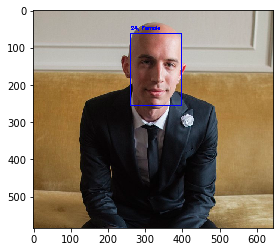

examples\input\neil_patrick_harris.png
age, gender: 24 Male


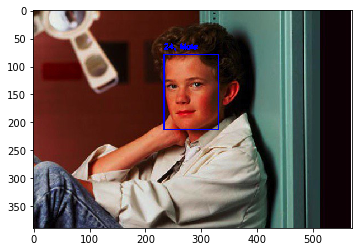

examples\input\samuel_l_jackson.png
age, gender: 32 Male


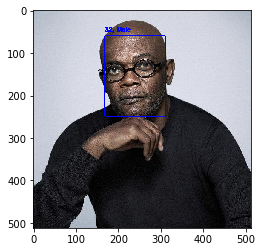

In [4]:
import argparse
import glob

def draw_label(image, box, label):
    """ opencvで予測した性別・年齢を画像に書き込む関数 """
    startX, startY =  box[0], box[1]
    endX, endY = box[0]+box[2], box[1]+box[3]
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    return image

def get_args():
    ap = argparse.ArgumentParser()
    #ap.add_argument("-i", "--images", default=[r"D:\iPhone_pictures\2011-09"], nargs='*', help="paths to input image")
    #ap.add_argument("-i", "--images", default=[r"D:\iPhone_pictures\2014-11"], nargs='*', help="paths to input image")
    ap.add_argument("-i", "--images", default=[r"examples\input"], nargs='*', help="paths to input image")
    ap.add_argument("-o", "--output_dir", default=r"examples\output", help="output dir path")
    ap.add_argument("-c", "--confidence", type=float, default=0.7, help="minimum probability to filter weak detections")
    ap.add_argument("-is_s", "--is_show", action='store_const', const=True, default=False, help="image show flag")
    #return vars(ap.parse_args())
    return vars(ap.parse_args(args=[])) # notebookで argparseそのままで実行する場合はこっち


if __name__ == '__main__':
    args = get_args()
    
    facenet_mtcnn = FaceNetMTCNN()
    age_gender = AgeGender()
    
    image_paths = glob.glob(os.path.join(args['images'][0], '*')) if os.path.isdir(args['images'][0]) else args['images']
    for img_path in image_paths:
        if str(pathlib.Path(img_path).suffix).lower() in ['.jpg', '.jpeg', '.png']:
            print(img_path)        
            img, face_detections = facenet_mtcnn.detect_face(img_path=img_path)
            # print(face_detections)
            
            for dic_det in face_detections:
                if dic_det['confidence'] > args['confidence']:
                    img_face = dic_det['box_img']

                    ## 顔画像確認用
                    #args['is_show'] = True
                    #if args['is_show']:
                    #    plt.imshow(img_face)
                    #    plt.show()

                    age, gender = age_gender.predict_img(img_face)
                    print('age, gender:', age, gender)
                    
                    image = draw_label(img, 
                               dic_det['box'], 
                               f"{str(age)}, {str(gender)}")
                    plt.imshow(image)
                    plt.show()
                    
                    # 出力画像保存
                    if args['output_dir'] is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(os.path.join(args['output_dir'], pathlib.Path(img_path).stem + '_detect.png'), image)
                